In [53]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import cv2
import glob
import math
from random import randint

In [54]:
images1 = [cv2.imread(file) for file in glob.glob("./office2/*.jpg")]

In [55]:
def FindBestMatch(images, idx):
    good = []
    MatchImgs = []
    targetImg = images[idx]
#     MatchImgs.append(targetImg)
    my_SIFT_instance = cv2.SIFT_create()
    kps1, des1 = my_SIFT_instance.detectAndCompute(targetImg, None) 
    for i in range(len(images) - 1):
        refImg = images[i]
        kps2, des2 = my_SIFT_instance.detectAndCompute(refImg, None) 
        matches = cv2.FlannBasedMatcher().knnMatch(des1, des2, k=2)
        for m, n in matches:
            if m.distance < 0.65 * n.distance:
                good.append([m])
        if len(good) > 5000:
             MatchImgs.append(refImg)
#     MatchImgs.append(targetImg)   
    return MatchImgs

In [56]:
images_test= FindBestMatch(images1,15)
print("good image matches are: ", len(images_test))

good image matches are:  13


In [57]:
images_test = images_test[1:6]

<Figure size 1200x800 with 0 Axes>

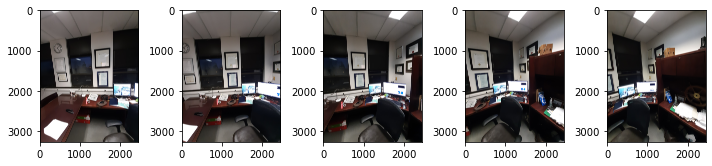

In [58]:
plt.figure(dpi=200)
plt.figure(figsize=(10,10))
for i in range(len(images_test)):
        plt.subplot(1,len(images_test),i+1)
        if(len(images_test[i].shape) == 2): 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv2.cvtColor(images_test[i], cv2.COLOR_BGR2RGB))
plt.tight_layout()

In [59]:
# images_test = [images1[0],images1[1],images1[2],images1[3],images1[4]]

In [60]:
def generateHomography(img1, img2):
    my_SIFT_instance = cv2.SIFT_create()
    kps1, des1 = my_SIFT_instance.detectAndCompute(img1, None)  
    kps2, des2 = my_SIFT_instance.detectAndCompute(img2, None)  
    matches = cv2.FlannBasedMatcher().knnMatch(des1, des2, k=2)
    good = []
    dis = []
    ptsLeft = []
    ptsRight = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])
            dis.append(m.distance)
            ptsLeft.append(kps1[m.queryIdx].pt)
            ptsRight.append(kps2[m.trainIdx].pt)
    img = np.zeros((img1.shape[0],img1.shape[1]), dtype=np.uint8)
    min_matches = 4
    if len(good) > min_matches:
        ptsLeft = np.int32(ptsLeft)
        ptsRight = np.int32(ptsRight)
#         F, mask = cv2.findFundamentalMat(ptsLeft, ptsRight, cv2.FM_RANSAC, 0.1)
        H, S = cv2.findHomography(ptsLeft, ptsRight, cv2.RANSAC,4)
        
        return H

In [61]:
def blendingMask(height, width, b, sw, left_biased=True):
    assert b < width
    mask = np.zeros((height, width))

    offset = int(sw / 2)
    try:
        if left_biased:
            mask[:, b - offset : b + offset + 1] = np.tile(np.linspace(1, 0, 2 * offset + 1).T, (height, 1))
            mask[:, : b - offset] = 1
        else:
            mask[:, b - offset : b + offset + 1] = np.tile(np.linspace(0, 1, 2 * offset + 1).T, (height, 1))
            mask[:, b + offset :] = 1
    except BaseException:
        if left_biased:
            mask[:, b - offset : b + offset + 1] = np.tile(np.linspace(1, 0, 2 * offset).T, (height, 1))
            mask[:, : b - offset] = 1
        else:
            mask[:, b - offset : b + offset + 1] = np.tile(np.linspace(0, 1, 2 * offset).T, (height, 1))
            mask[:, b + offset :] = 1

    return cv2.merge([mask, mask, mask])

In [62]:
def panoramaBlending(dr, src, wd, side):

    h, w, _ = dr.shape
    sw = int(wd / 8)
    b = wd - int(sw / 2)
    mask1 = blendingMask(h, w, b, sw=sw, left_biased=True)
    mask2 = blendingMask(h, w, b, sw=sw, left_biased=False)
  
    if side == "L":
        dr = cv2.flip(dr, 1)
        src = cv2.flip(src, 1)
        dr = dr * mask1
        src = src * mask2
        pano = src + dr
        pano = cv2.flip(pano, 1)
        
    else:
        dr = dr * mask1
        src = src * mask2
        pano = src + dr

    return pano

In [63]:
def sideDetermine(pts, pts1_,  wd, t):
    if pts[0][0][0] < 0:
        side = "L"
        wp = wd + t[0]
    else:
        side = "R"
        wp = int(pts1_[3][0][0])
    return side, wp

In [64]:
def warpImages(img1, img2):
    H = generateHomography(img1, img2)

    hs, ws = img1.shape[:2]
    hd, wd = img2.shape[:2]
    
    pts1 = np.float32([[0, 0], [0, hs], [ws, hs], [ws, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, hd], [wd, hd], [wd, 0]]).reshape(-1, 1, 2)

    pts1_ = cv2.perspectiveTransform(pts1, H)
    pts = np.concatenate((pts1_, pts2), axis=0)
    
    [xmin, ymin] = np.int64(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int64(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    
    side, wp = sideDetermine(pts, pts1_, wd, t)

    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
    src = cv2.warpPerspective(img1, Ht.dot(H), (wp, ymax - ymin))
    
    dr = np.zeros((ymax - ymin, wp, 3))
    if side == "L":
        dr[t[1] : hs + t[1], t[0] : wd + t[0]] = img2
    else:
        dr[t[1] : hs + t[1], :wd] = img2
    pts = pts.astype(int)
    return pts, dr, src, wd, side, t

In [65]:
def blendAndCrop(img1, img2):
    hs, ws = img1.shape[:2]
    hd, wd = img2.shape[:2]
    pts, dr, src, wd, side, t = warpImages(img1, img2)
  
    pano = panoramaBlending(dr, src, wd, side)

   
    if pts[0][0][0] < 0:
        n = abs(-pts[1][0][0] + pts[0][0][0])
        pano = pano[t[1] : hd + t[1], n:, :]
    else:
        if pts[2][0][0] < pts[3][0][0]:
            pano = pano[t[1] : hd + t[1], 0 : pts[2][0][0], :]
        else:
            pano = pano[t[1] : hd + t[1], 0 : pts[3][0][0], :]
   
    return pano

In [66]:
def splitImageList(list_images):
    n = int(len(list_images)/2 + 0.5)
    left = []
    right = []
    for i in range(len(list_images)):
        if(i<n):
            left.append(list_images[i])
        else:
            right.append(list_images[i])
    right.reverse()
    return left, right

In [67]:
def mergeTwoLists(list_images):
    while len(list_images) > 1:
        img1 = list_images.pop()
        img2 = list_images.pop()
        pano = blendAndCrop(img2, img1)
        pano = pano.astype("uint8")
        list_images.append(pano)
    return list_images, pano

In [68]:
def multiStitching(list_images):
    left, right = splitImageList(list_images)
    left, p1 = mergeTwoLists(left)
    right, p2 = mergeTwoLists(right)

    if p2.shape[1] >= p1.shape[1]:
        fullpano = blendAndCrop(p1, p2)
    else:
        fullpano = blendAndCrop(p2, p1)
    return fullpano

In [69]:
panorama = multiStitching(images_test)
img_float32 = np.float32(panorama)

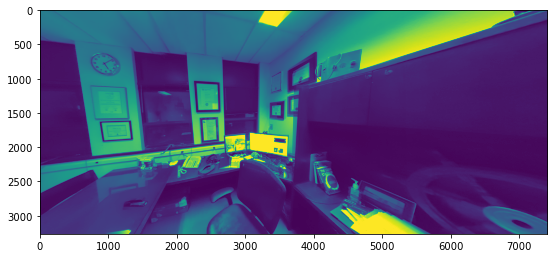

In [70]:
fig, axes = plt.subplots(1, 1, figsize=(20,20))
plt.subplot(121), plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2GRAY))
plt.show()